In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as T
from PIL import Image

from collections import defaultdict
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import seaborn as sns

device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Using device:", device)

Using device: mps


In [ ]:
# Paths & CSV Load
CSV_PATH = "data/asl_all_with_skin_tones.csv"    
BASELINE_MODEL_PATH = "asl_resnet18_baseline_best.pth"
DEBIASED_MODEL_PATH = "asl_debiased_best.pth"

df = pd.read_csv(CSV_PATH)
print("Loaded df:", df.shape)

# Keep only rows where the image file exists
df = df[df["filepath"].apply(os.path.exists)].reset_index(drop=True)
print("After path filter:", df.shape)

Loaded df: (42000, 8)
After path filter: (42000, 8)


In [ ]:
# Label & Skin-Tone Mappings
letters = sorted(df["letter"].unique())
letter_to_id = {l: i for i, l in enumerate(letters)}
id_to_letter = {i: l for l, i in letter_to_id.items()}

df["label_id"] = df["letter"].map(letter_to_id)

tones = sorted(df["skin_tone_final"].unique())  # e.g. ["dark", "light", "medium"]
skin_to_id = {t: i for i, t in enumerate(tones)}
id_to_skin = {i: t for t, i in skin_to_id.items()}

df["skin_tone_id_final"] = df["skin_tone_final"].map(skin_to_id)

print("Letters:", letters)
print("Skin tones:", tones)

Letters: ['A', 'B', 'C', 'D', 'DEL', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Skin tones: ['dark', 'light', 'medium']


In [ ]:
# Train / Val / Test Split (rebuild like training)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label_id"],
    random_state=42,
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df["label_id"],
    random_state=42,
)

print(f"train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")


train: 30240, val: 7560, test: 4200


In [ ]:
# Dataset & DataLoader (Validation set)
val_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class ASLValDataset(Dataset):
    def __init__(self, df, transform, skin_to_id):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.skin_to_id = skin_to_id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")
        img = self.transform(img)

        label = int(row["label_id"])
        skin = row["skin_tone_final"]
        skin_id = self.skin_to_id[skin]

        return img, label, skin_id

val_dataset = ASLValDataset(val_df, val_transform, skin_to_id)
val_loader2 = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

# Quick sanity check
imgs, labels, skin_ids = next(iter(val_loader2))
print("Batch shape:", imgs.shape)
print("Labels example:", labels[:5])
print("Skin ids example:", skin_ids[:5])


Batch shape: torch.Size([64, 3, 224, 224])
Labels example: tensor([ 5, 15, 18, 24,  7])
Skin ids example: tensor([2, 2, 2, 2, 2])


In [ ]:
# Debiased Model Architecture (GRL + ResNet18)
from torch.autograd import Function

class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)

class ASLResNet18Debiased(nn.Module):
    def __init__(self, num_letters, num_skin_tones, alpha=0.1):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.asl_head = nn.Linear(in_features, num_letters)

        self.grl = GradientReversalLayer(alpha=alpha)
        self.skin_head = nn.Linear(in_features, num_skin_tones)

    def forward(self, x):
        features = self.backbone(x)
        asl_logits = self.asl_head(features)
        skin_logits = self.skin_head(self.grl(features))
        return asl_logits, skin_logits


# Load Baseline & Debiased Models
num_letters = len(letters)
num_skin_tones = len(tones)

# Baseline ResNet-18
baseline_model = models.resnet18(weights=None)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, num_letters)
baseline_state = torch.load(BASELINE_MODEL_PATH, map_location=device)
baseline_model.load_state_dict(baseline_state)
baseline_model = baseline_model.to(device).eval()

# Debiased ResNet-18 with GRL
debiased_model = ASLResNet18Debiased(
    num_letters=num_letters,
    num_skin_tones=num_skin_tones,
    alpha=0.1  # match training
).to(device)

deb_state = torch.load(DEBIASED_MODEL_PATH, map_location=device)
debiased_model.load_state_dict(deb_state)
debiased_model.eval()

print("Models loaded.")

Models loaded.


In [ ]:
# SIGN Accuracy by Skin Tone (Baseline vs Debiased)
def sign_accuracy_by_skin_tone(model, loader, device):
    model.eval()
    correct = defaultdict(int)
    total   = defaultdict(int)

    with torch.no_grad():
        for images, labels, skin_ids in loader:
            images = images.to(device)
            labels = labels.to(device)

            out = model(images)
            if isinstance(out, tuple):   # debiased: (asl_logits, skin_logits)
                asl_logits = out[0]
            else:                        # baseline: logits
                asl_logits = out

            preds = asl_logits.argmax(dim=1)
            matches = (preds == labels).cpu().numpy()
            skin_ids_np = skin_ids.numpy()

            for ok, sid in zip(matches, skin_ids_np):
                tone = id_to_skin[int(sid)]
                total[tone] += 1
                if ok:
                    correct[tone] += 1

    acc = {tone: correct[tone] / total[tone] for tone in total}
    return acc, correct, total

base_acc, base_correct, base_total = sign_accuracy_by_skin_tone(
    baseline_model, val_loader2, device
)
deb_acc, deb_correct, deb_total = sign_accuracy_by_skin_tone(
    debiased_model, val_loader2, device
)

print("Baseline SIGN accuracy by skin tone:")
for t in tones:
    print(f"{t:6s}: {base_acc[t]*100:5.2f}%  ({base_correct[t]}/{base_total[t]})")

print("\nDebiased SIGN accuracy by skin tone:")
for t in tones:
    print(f"{t:6s}: {deb_acc[t]*100:5.2f}%  ({deb_correct[t]}/{deb_total[t]})")

# Summary table
summary = pd.DataFrame(
    {
        "Baseline_Acc_%": {t: base_acc[t]*100 for t in tones},
        "Debiased_Acc_%": {t: deb_acc[t]*100 for t in tones},
    }
)
summary["Delta_(Deb-Baseline)"] = summary["Debiased_Acc_%"] - summary["Baseline_Acc_%"]
summary



Baseline SIGN accuracy by skin tone:
dark  : 100.00%  (2114/2114)
light : 100.00%  (2760/2760)
medium: 100.00%  (2686/2686)

Debiased SIGN accuracy by skin tone:
dark  : 99.95%  (2113/2114)
light : 99.82%  (2755/2760)
medium: 100.00%  (2686/2686)


,Baseline_Acc_%,Debiased_Acc_%,Delta_(Deb-Baseline)
dark,100.0,99.952696,-0.047304
light,100.0,99.818841,-0.181159
medium,100.0,100.000000,0.000000


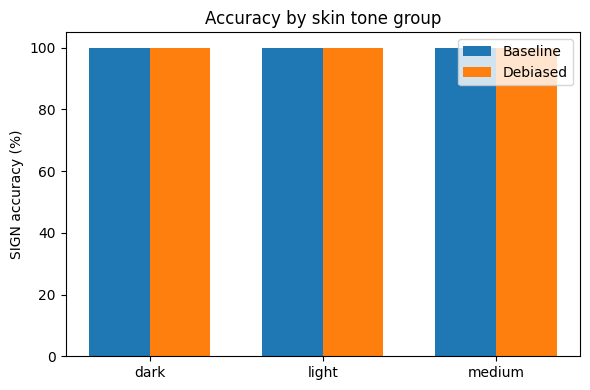

In [13]:
# Bar plot
x = np.arange(len(tones))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, [base_acc[t]*100 for t in tones], width, label="Baseline")
plt.bar(x + width/2, [deb_acc[t]*100 for t in tones], width, label="Debiased")
plt.xticks(x, tones)
plt.ylabel("SIGN accuracy (%)")
plt.title("Accuracy by skin tone group")
plt.legend()
plt.tight_layout()
plt.show()



========== DARK EXAMPLES ==========


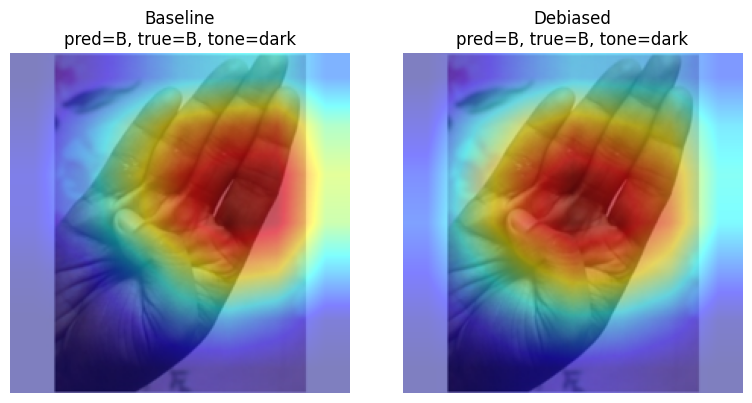

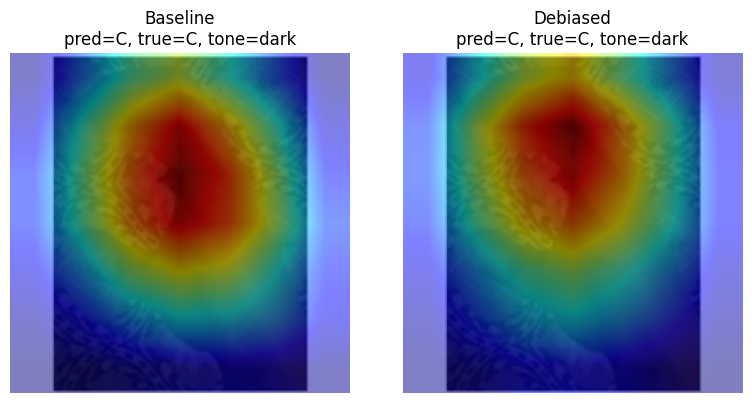

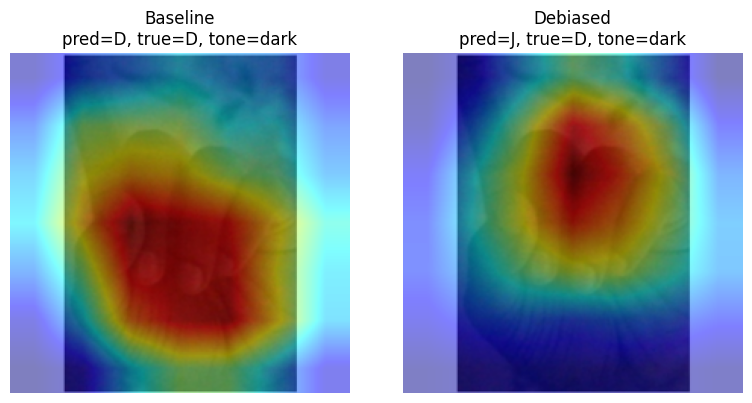


========== LIGHT EXAMPLES ==========


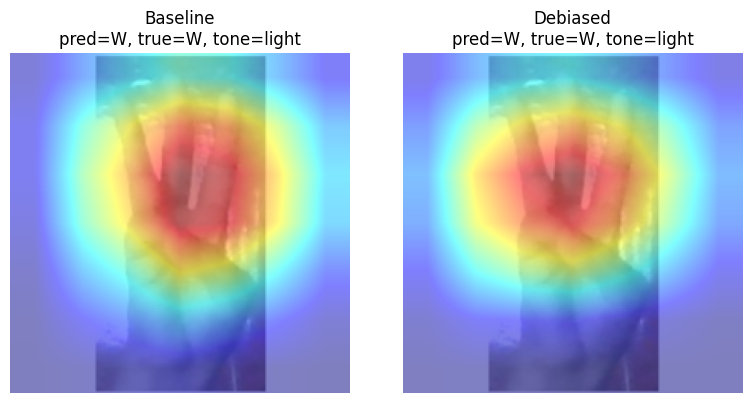

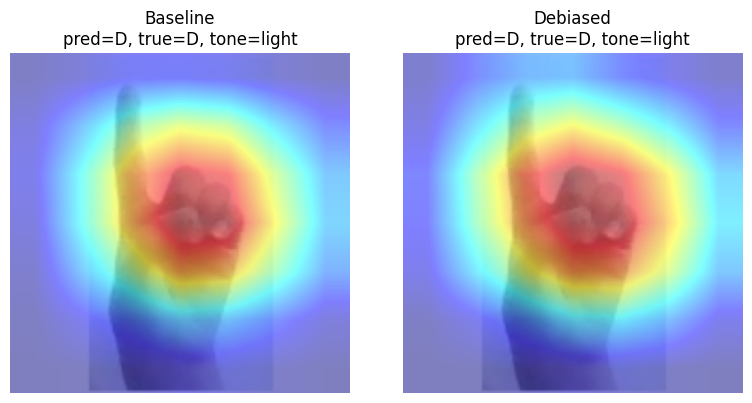

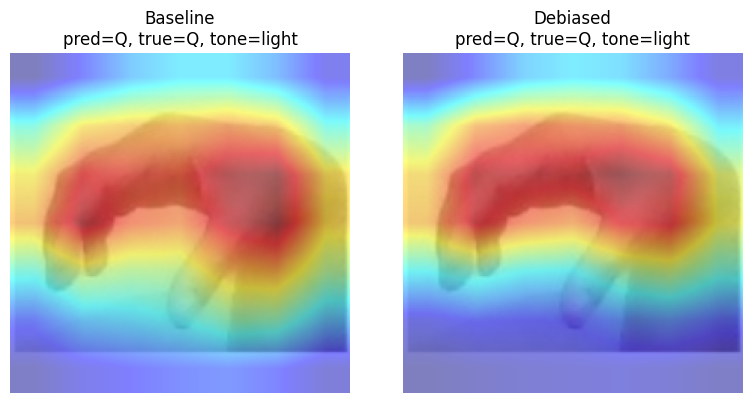


========== MEDIUM EXAMPLES ==========


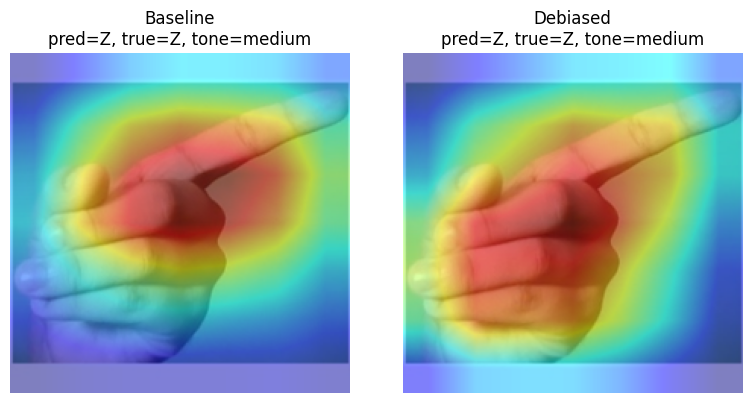

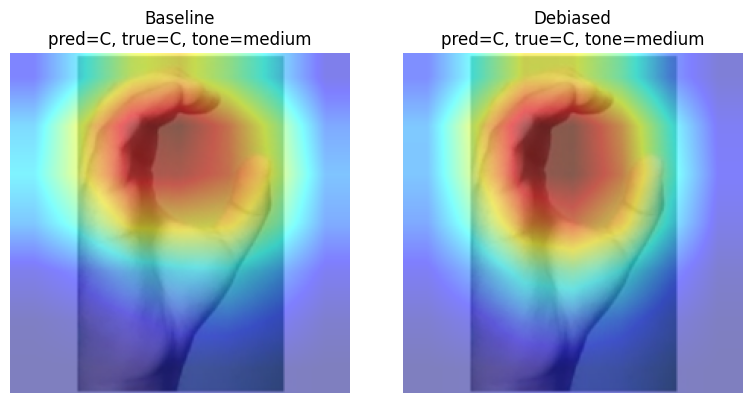

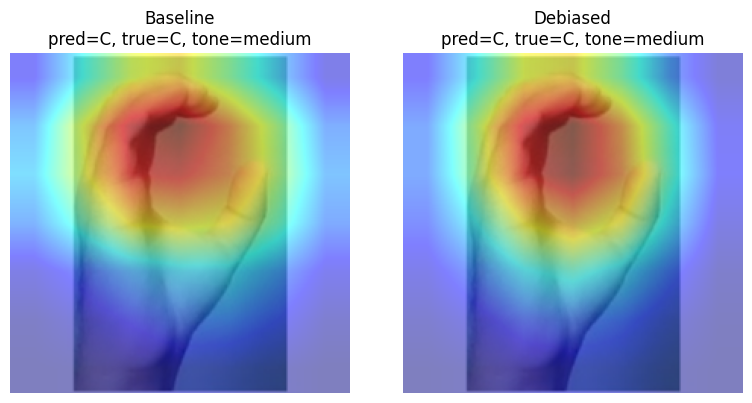

In [ ]:
# Grad-CAM: Baseline vs Debiased (Visual Examples)
target_layers_base = [baseline_model.layer4[-1]]
target_layers_deb  = [debiased_model.backbone.layer4[-1]]

def gradcam_for_model_on_row(row, model, device, target_layers, title_prefix=""):
    img_path = row["filepath"]
    true_letter = row["letter"]
    skin_tone = row["skin_tone_final"]

    pil_img = Image.open(img_path).convert("RGB")
    pil_resized = pil_img.resize((224, 224))
    rgb_img = np.float32(pil_resized) / 255.0

    input_tensor = val_transform(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(input_tensor)
        if isinstance(out, tuple):
            logits = out[0]
        else:
            logits = out
        pred_id = logits.argmax(dim=1).item()

    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred_id)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    pred_letter = id_to_letter[pred_id]

    plt.imshow(visualization)
    plt.axis("off")
    plt.title(f"{title_prefix}\npred={pred_letter}, true={true_letter}, tone={skin_tone}")

def compare_gradcam_on_row(row, baseline_model, debiased_model,
                           target_layers_base, target_layers_deb, device):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    gradcam_for_model_on_row(row, baseline_model, device, target_layers_base, "Baseline")

    plt.subplot(1,2,2)
    gradcam_for_model_on_row(row, debiased_model, device, target_layers_deb, "Debiased")

    plt.tight_layout()
    plt.show()

np.random.seed(0)

for tone in tones:
    print(f"\n========== {tone.upper()} EXAMPLES ==========")
    subset = val_df[val_df["skin_tone_final"] == tone]
    subset = subset.sample(3, random_state=0)  # 3 examples per tone

    for _, row in subset.iterrows():
        compare_gradcam_on_row(row, baseline_model, debiased_model,
                               target_layers_base, target_layers_deb, device)



In [ ]:
# Hand-Focus Scores (Center CAM Energy)
def compute_hand_focus_for_row(row, model, device, target_layers):
    img_path = row["filepath"]
    true_label_id = int(row["label_id"])

    pil_img = Image.open(img_path).convert("RGB")
    input_tensor = val_transform(pil_img).unsqueeze(0).to(device)

    model.eval()
    for p in model.parameters():
        p.requires_grad_(True)

    out = model(input_tensor)
    if isinstance(out, tuple):
        logits = out[0]
    else:
        logits = out

    pred_id = logits.argmax(dim=1).item()
    if pred_id != true_label_id:
        return None

    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred_id)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    cam_map = grayscale_cam.astype(np.float32)
    cam_map = np.maximum(cam_map, 0)
    total = cam_map.sum() + 1e-6

    H, W = cam_map.shape
    y0, y1 = int(0.25 * H), int(0.75 * H)
    x0, x1 = int(0.25 * W), int(0.75 * W)
    hand_region = cam_map[y0:y1, x0:x1]
    hand_sum = hand_region.sum()

    return hand_sum / total

def collect_focus_scores(model, target_layers, val_df, tones, device,
                         max_per_tone=50):
    scores = {}
    for tone in tones:
        print(f"\n=== Collecting CAM scores for tone: {tone} ===")
        subset = val_df[val_df["skin_tone_final"] == tone].copy()
        subset = subset.sample(min(len(subset), max_per_tone * 3), random_state=42)
        subset = subset.reset_index(drop=True)

        tone_scores = []
        for _, row in subset.iterrows():
            if len(tone_scores) >= max_per_tone:
                break
            s = compute_hand_focus_for_row(row, model, device, target_layers)
            if s is not None:
                tone_scores.append(s)
                if len(tone_scores) % 10 == 0:
                    print(f"  {tone}: {len(tone_scores)} scores...")
        scores[tone] = tone_scores
        print(f"Collected {len(tone_scores)} valid {tone} scores")
    return scores

scores_base = collect_focus_scores(
    baseline_model, target_layers_base, val_df, tones, device, max_per_tone=50
)
scores_deb = collect_focus_scores(
    debiased_model, target_layers_deb, val_df, tones, device, max_per_tone=50
)

print("\nBaseline CAM hand-focus stats:")
for t in tones:
    arr = np.array(scores_base[t])
    print(f"{t:6s}: n={len(arr)}, mean={arr.mean():.3f}, std={arr.std():.3f}")

print("\nDebiased CAM hand-focus stats:")
for t in tones:
    arr = np.array(scores_deb[t])
    print(f"{t:6s}: n={len(arr)}, mean={arr.mean():.3f}, std={arr.std():.3f}")



=== Collecting CAM scores for tone: dark ===
  dark: 10 scores...
  dark: 20 scores...
  dark: 30 scores...
  dark: 40 scores...
  dark: 50 scores...
Collected 50 valid dark scores

=== Collecting CAM scores for tone: light ===
  light: 10 scores...
  light: 20 scores...
  light: 30 scores...
  light: 40 scores...
  light: 50 scores...
Collected 50 valid light scores

=== Collecting CAM scores for tone: medium ===
  medium: 10 scores...
  medium: 20 scores...
  medium: 30 scores...
  medium: 40 scores...
  medium: 50 scores...
Collected 50 valid medium scores

=== Collecting CAM scores for tone: dark ===
  dark: 10 scores...
  dark: 20 scores...
  dark: 30 scores...
  dark: 40 scores...
  dark: 50 scores...
Collected 50 valid dark scores

=== Collecting CAM scores for tone: light ===
  light: 10 scores...
  light: 20 scores...
  light: 30 scores...
  light: 40 scores...
  light: 50 scores...
Collected 50 valid light scores

=== Collecting CAM scores for tone: medium ===
  medium: 10 s

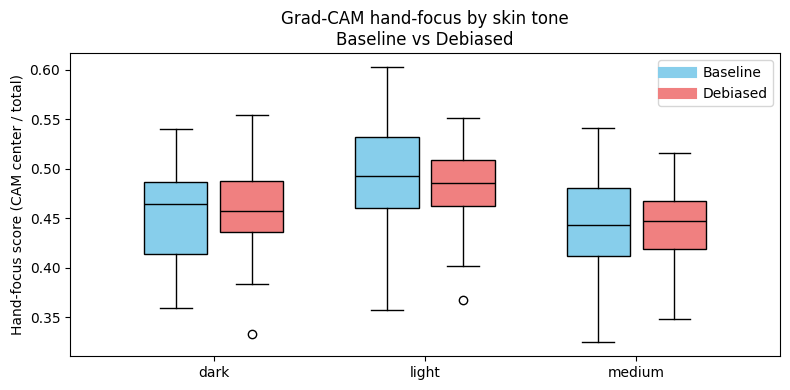

In [16]:
# Boxplots for hand focus
plt.figure(figsize=(8,4))

positions_base = np.arange(len(tones)) - 0.18
positions_deb  = np.arange(len(tones)) + 0.18

plt.boxplot(
    [scores_base[t] for t in tones],
    positions=positions_base,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue"),
    medianprops=dict(color="black")
)

plt.boxplot(
    [scores_deb[t] for t in tones],
    positions=positions_deb,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="lightcoral"),
    medianprops=dict(color="black")
)

plt.xticks(np.arange(len(tones)), tones)
plt.ylabel("Hand-focus score (CAM center / total)")
plt.title("Grad-CAM hand-focus by skin tone\nBaseline vs Debiased")

baseline_patch = plt.Line2D([0], [0], color="skyblue", lw=8)
debiased_patch = plt.Line2D([0], [0], color="lightcoral", lw=8)
plt.legend([baseline_patch, debiased_patch], ["Baseline", "Debiased"], loc="best")

plt.tight_layout()
plt.show()


In [ ]:
# t-tests on Hand-Focus (Baseline vs Debiased)
print("\nT-tests for hand-focus scores (Debiased vs Baseline):")
for t in tones:
    base_scores = np.array(scores_base[t])
    deb_scores  = np.array(scores_deb[t])
    stat, p = ttest_ind(base_scores, deb_scores, equal_var=False)
    print(f"{t:6s}: t={stat:.3f}, p={p:.5f}")




T-tests for hand-focus scores (Debiased vs Baseline):
dark  : t=-0.205, p=0.83773
light : t=1.124, p=0.26388
medium: t=0.489, p=0.62610


In [ ]:
# Skin-tone Head Accuracy + Confusion Matrix (Debiased)
def skin_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_true = []
    all_pred = []

    with torch.no_grad():
        for images, labels, skin_ids in loader:
            images = images.to(device)
            skin_ids = skin_ids.to(device)

            _, skin_logits = model(images)
            preds = skin_logits.argmax(1)

            correct += (preds == skin_ids).sum().item()
            total += skin_ids.size(0)

            all_true.extend(skin_ids.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())

    acc = correct / total
    cm = confusion_matrix(all_true, all_pred)
    return acc, cm

skin_acc, cm = skin_accuracy(debiased_model, val_loader2, device)
print("\nDebiased skin-tone head accuracy:", skin_acc * 100, "%")
print("Confusion matrix (rows=true, cols=pred):")
print(cm)



Debiased skin-tone head accuracy: 25.56878306878307 %
Confusion matrix (rows=true, cols=pred):
[[1454  659    1]
 [2115  473  172]
 [2357  323    6]]


Other EDA

Overall skin tone distribution:


,count,percent
skin_tone_final,,
dark,11884,28.30
light,15296,36.42
medium,14820,35.29


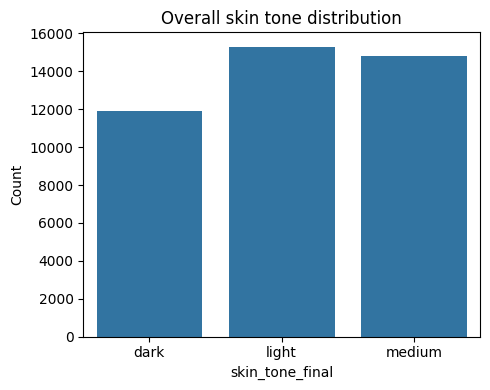

Per-letter counts by skin tone:


skin_tone_final,dark,light,medium
letter,,,
A,490,510,500
B,488,501,511
C,234,697,569
D,494,499,507
DEL,463,527,510
E,431,517,552
F,497,503,500
G,367,552,581
H,401,502,597


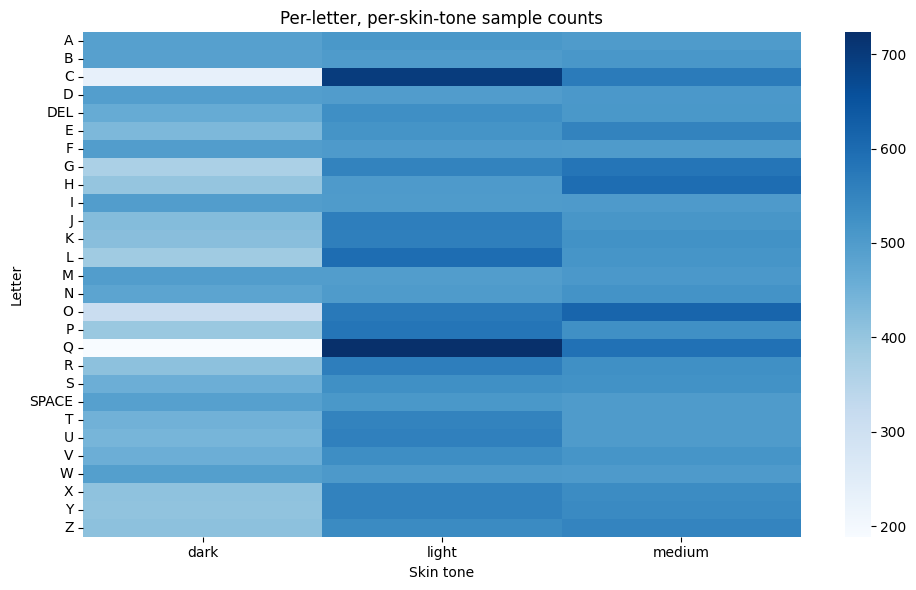

In [ ]:
# Overall distribution of skin tones
skin_counts = df["skin_tone_final"].value_counts().reindex(tones)
skin_percent = 100 * skin_counts / skin_counts.sum()

print("Overall skin tone distribution:")
display(pd.DataFrame({
    "count": skin_counts,
    "percent": skin_percent.round(2)
}))

plt.figure(figsize=(5,4))
sns.barplot(x=skin_counts.index, y=skin_counts.values)
plt.ylabel("Count")
plt.title("Overall skin tone distribution")
plt.tight_layout()
plt.show()

# Per-letter distribution by skin tone
letter_tone_counts = (
    df.groupby(["letter", "skin_tone_final"])
      .size()
      .unstack(fill_value=0)
      .reindex(index=letters, columns=tones)
)

print("Per-letter counts by skin tone:")
display(letter_tone_counts)

plt.figure(figsize=(10,6))
sns.heatmap(letter_tone_counts, annot=False, cmap="Blues")
plt.title("Per-letter, per-skin-tone sample counts")
plt.xlabel("Skin tone")
plt.ylabel("Letter")
plt.tight_layout()
plt.show()
